# PROBLEM STATEMENT 1
This is the implementation of JPEG. The initial parts are the step by step breakdown. The final code is at the end which does everything, saves the data as a .json file and then is able read from it and then reconstruct the file from this data.

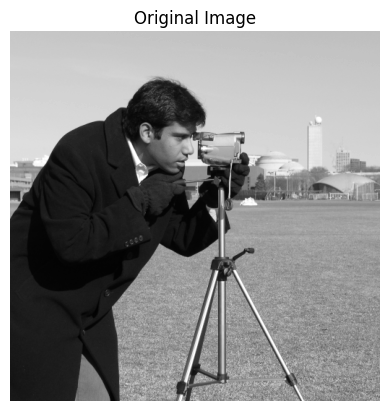

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

def load_sample_image():
    image = data.camera()
    return np.float32(image) - 128  # Center pixel values around zero

# Load sample image
image = load_sample_image()

# Display original image
plt.imshow(image + 128, cmap='gray')  # Shift back pixel values for display
plt.title("Original Image")
plt.axis("off")
plt.savefig('original_image.png')
plt.show()


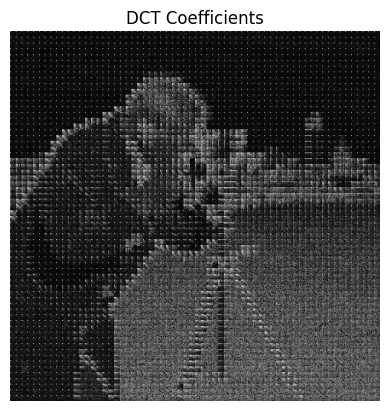

In [ ]:
from scipy.fftpack import dct

def compute_dct_coefficients(image, block_size=8):
    h, w = image.shape
    dct_coefficients = np.zeros_like(image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')  # 2D DCT
            dct_coefficients[i:i+block_size, j:j+block_size] = dct_block

    return dct_coefficients

# Compute DCT coefficients
dct_image = compute_dct_coefficients(image)

# Display DCT coefficients
plt.imshow(np.log(np.abs(dct_image) + 1), cmap='gray')  # Log for better visibility
plt.title("DCT Coefficients")
plt.axis("off")
plt.savefig('dct_coefficients.png')
plt.show()

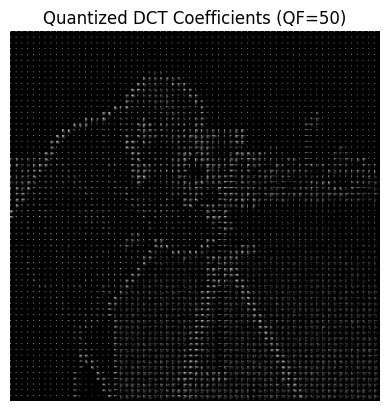

In [ ]:
# Standard Quantization Matrix for QF=50
Q_MATRIX_50 = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Quantization Matrix based on Quality Factor (QF)
def get_quantization_matrix(QF):
    scale = 5000 / QF if QF < 50 else 200 - 2 * QF
    quantization_matrix = np.floor((Q_MATRIX_50 * scale + 50) / 100)
    quantization_matrix = np.clip(quantization_matrix, 1, 255)
    return quantization_matrix

# Quantize DCT coefficients
def quantize(dct_block, q_matrix):
    return np.round(dct_block / q_matrix)

# Apply quantization to DCT coefficients
def apply_quantization(dct_image, QF, block_size=8):
    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image)

    q_matrix = get_quantization_matrix(QF)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i+block_size, j:j+block_size]
            quantized_dct[i:i+block_size, j:j+block_size] = quantize(block, q_matrix)

    return quantized_dct

# Apply quantization with a quality factor of 50
quantized_dct_image = apply_quantization(dct_image, 50)

# Display quantized DCT coefficients
plt.imshow(np.log(np.abs(quantized_dct_image) + 1), cmap='gray')  # Log for better visibility
plt.title("Quantized DCT Coefficients (QF=50)")
plt.axis("off")
plt.savefig('quantized_dct_coefficients.png')
plt.show()


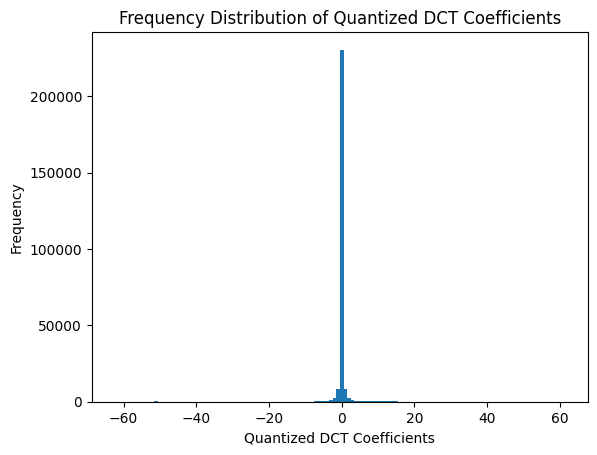

In [ ]:
from collections import Counter

# Compute frequency of quantized DCT coefficients
def compute_frequencies(quantized_dct_image):
    flat_values = quantized_dct_image.flatten()
    return Counter(flat_values)

# Compute frequencies of quantized DCT coefficients
frequencies = compute_frequencies(quantized_dct_image)

# Plot the frequency distribution of the quantized coefficients
plt.bar(frequencies.keys(), frequencies.values(), width=1.0)
plt.title("Frequency Distribution of Quantized DCT Coefficients")
plt.xlabel("Quantized DCT Coefficients")
plt.ylabel("Frequency")
plt.savefig('quantized_dct_frequencies.png')
plt.show()


In [ ]:
import heapq

# Huffman Tree Node
class Node:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

# Build Huffman Tree
def build_huffman_tree(frequencies):
    heap = [Node(symbol, freq) for symbol, freq in frequencies.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = Node(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)

    return heap[0] if heap else None

# Generate Huffman Codes
def generate_huffman_codes(node, prefix="", codebook=None):
    if codebook is None:
        codebook = {}

    if node is not None:
        if node.symbol is not None:
            codebook[node.symbol] = prefix
        else:
            generate_huffman_codes(node.left, prefix + "0", codebook)
            generate_huffman_codes(node.right, prefix + "1", codebook)

    return codebook

# Build Huffman Tree
huffman_tree = build_huffman_tree(frequencies)

# Generate Huffman Codes
codebook = generate_huffman_codes(huffman_tree)

# Display a portion of the Huffman Codes
sample_codes = dict(list(codebook.items())[:10])  # Display the first 10 codes
print("Sample Huffman Codes: ", sample_codes)

Sample Huffman Codes:  {-50.0: '00000000', 16.0: '00000001', 19.0: '0000001000', -43.0: '00000010010', -28.0: '00000010011', -53.0: '000000101', -14.0: '0000001100', -56.0: '0000001101', 20.0: '0000001110', 47.0: '00000011110'}


In [ ]:
# Encode quantized DCT coefficients using the Huffman codes
def huffman_encode(quantized_dct_image, codebook):
    flat_values = quantized_dct_image.flatten()
    encoded_image = ''.join([codebook[value] for value in flat_values])
    return encoded_image

# Encode the quantized DCT image
encoded_image = huffman_encode(quantized_dct_image, codebook)

# Display the length of the encoded image (number of bits)
print(f"Encoded Image Length (in bits): {len(encoded_image)}")


Encoded Image Length (in bits): 384507


In [ ]:
# Decode Huffman encoded data
def huffman_decode(encoded_data, codebook):
    reverse_codebook = {v: k for k, v in codebook.items()}
    decoded_values = []
    current_code = ""

    for bit in encoded_data:
        current_code += bit
        if current_code in reverse_codebook:
            decoded_values.append(reverse_codebook[current_code])
            current_code = ""  # Reset after decoding a symbol

    return np.array(decoded_values)

# Decode the encoded image
decoded_values = huffman_decode(encoded_image, codebook)

# Reshape the decoded values back to the quantized DCT image shape
decoded_quantized_dct_image = decoded_values.reshape(quantized_dct_image.shape)

# Display the first few decoded coefficients to verify the process
print("Decoded DCT Coefficients (first 10 values): ", decoded_quantized_dct_image.flatten()[:10])


Decoded DCT Coefficients (first 10 values):  [36.  0.  0.  0.  0.  0.  0.  0. 35.  0.]


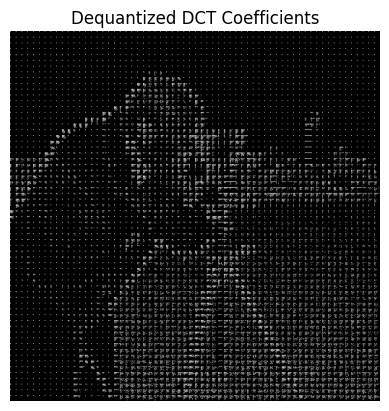

In [ ]:
# Dequantize DCT coefficients
def dequantize(quantized_dct_image, q_matrix=Q_MATRIX_50, block_size=8):
    h, w = quantized_dct_image.shape
    dequantized_image = np.zeros_like(quantized_dct_image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = quantized_dct_image[i:i+block_size, j:j+block_size]
            dequantized_image[i:i+block_size, j:j+block_size] = block * q_matrix

    return dequantized_image

# Dequantize the decoded DCT coefficients
dequantized_dct_image = dequantize(decoded_quantized_dct_image)

# Display the dequantized DCT coefficients
plt.imshow(np.log(np.abs(dequantized_dct_image) + 1), cmap='gray')
plt.title("Dequantized DCT Coefficients")
plt.axis("off")
plt.savefig('dequantized_dct_coefficients.png')
plt.show()


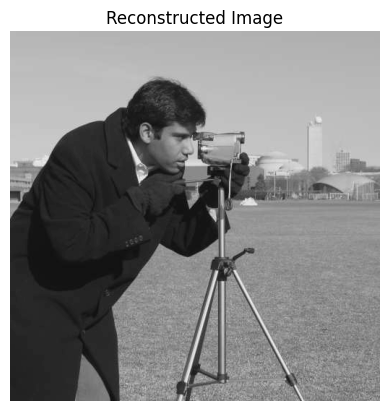

In [ ]:
from scipy.fftpack import idct

# Inverse DCT to reconstruct the image
def inverse_dct(dct_image, block_size=8):
    h, w = dct_image.shape
    reconstructed_image = np.zeros_like(dct_image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i+block_size, j:j+block_size]
            idct_block = idct(idct(block.T, norm='ortho').T, norm='ortho')
            reconstructed_image[i:i+block_size, j:j+block_size] = idct_block

    return reconstructed_image

# Reconstruct the image from the dequantized DCT coefficients
reconstructed_image = inverse_dct(dequantized_dct_image)

# Display the reconstructed image
plt.imshow(reconstructed_image + 128, cmap='gray')  # Shift back pixel values for display
plt.title("Reconstructed Image")
plt.axis("off")
plt.savefig('reconstructed_image.png')
plt.show()


In [ ]:
# Compute RMSE (Root Mean Squared Error)
def compute_rmse(original, decompressed):
    return np.sqrt(np.mean((original - decompressed) ** 2))

# Compute BPP (bits per pixel)
def compute_bpp(encoded_image, original_image):
    num_pixels = original_image.size
    num_bits = len(encoded_image)
    return num_bits / num_pixels

# Compute RMSE between the original and reconstructed image
rmse = compute_rmse(image, reconstructed_image)

# Compute BPP of the encoded image
bpp = compute_bpp(encoded_image, image)

# Print RMSE and BPP values
print(f"RMSE: {rmse}")
print(f"BPP: {bpp}")

RMSE: 5.991006851196289
BPP: 1.4667778015136719


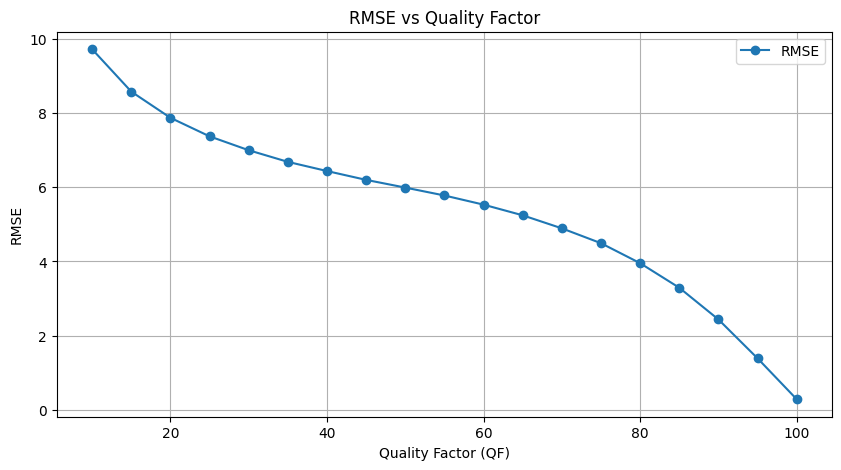

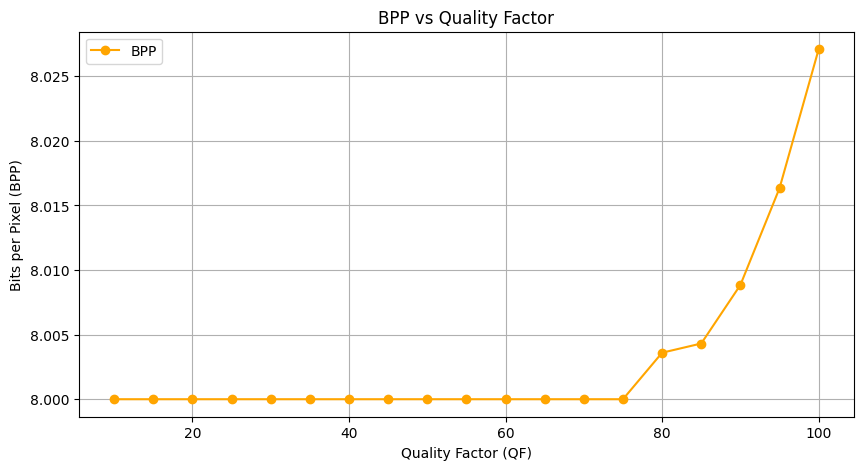

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from scipy.fftpack import dct, idct

# Load sample image (grayscale)
def load_sample_image():
    image = data.camera()  # Load the camera image
    return np.float32(image) - 128  # Center pixel values around zero

# Compute 2D DCT on non-overlapping blocks
def compute_dct_coefficients(image, block_size=8):
    h, w = image.shape
    dct_coefficients = np.zeros_like(image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')  # 2D DCT
            dct_coefficients[i:i+block_size, j:j+block_size] = dct_block

    return dct_coefficients

# Quantization matrix based on Quality Factor (QF)
def get_quantization_matrix(QF):
    Q_MATRIX_50 = np.array([  # Standard quantization matrix for QF=50
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])
    scale = 5000 / QF if QF < 50 else 200 - 2 * QF
    quantization_matrix = np.floor((Q_MATRIX_50 * scale + 50) / 100)
    quantization_matrix = np.clip(quantization_matrix, 1, 255)
    return quantization_matrix

# Quantize DCT coefficients
def quantize(dct_block, q_matrix):
    return np.round(dct_block / q_matrix)

# Apply quantization to DCT coefficients
def apply_quantization(dct_image, QF, block_size=8):
    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image)
    q_matrix = get_quantization_matrix(QF)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i+block_size, j:j+block_size]
            quantized_dct[i:i+block_size, j:j+block_size] = quantize(block, q_matrix)

    return quantized_dct

# Dequantize DCT coefficients
def dequantize(quantized_dct_image, q_matrix, block_size=8):
    h, w = quantized_dct_image.shape
    dequantized_image = np.zeros_like(quantized_dct_image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = quantized_dct_image[i:i+block_size, j:j+block_size]
            dequantized_image[i:i+block_size, j:j+block_size] = block * q_matrix

    return dequantized_image

# Inverse DCT to reconstruct the image
def inverse_dct(dct_image, block_size=8):
    h, w = dct_image.shape
    reconstructed_image = np.zeros_like(dct_image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i+block_size, j:j+block_size]
            idct_block = idct(idct(block.T, norm='ortho').T, norm='ortho')
            reconstructed_image[i:i+block_size, j:j+block_size] = idct_block

    return reconstructed_image

# Compute RMSE (Root Mean Squared Error)
def compute_rmse(original, decompressed):
    return np.sqrt(np.mean((original - decompressed) ** 2))

# Compute BPP (bits per pixel)
def compute_bpp(encoded_image, original_image):
    num_pixels = original_image.size
    num_bits = len(encoded_image)
    return num_bits / num_pixels

# Simulate QF vs RMSE and BPP
def simulate_qf_vs_rmse_bpp(image):
    qf_values = range(10, 101, 5)  # Specific QF values
    rmse_values = []
    bpp_values = []
    for QF in qf_values:
        # Step 1: Apply DCT
        dct_image = compute_dct_coefficients(image)

        # Step 2: Quantize DCT coefficients
        quantized_dct_image = apply_quantization(dct_image, QF)

        # Step 3: Huffman encoding (simulated using dummy encoding)
        flat_values = quantized_dct_image.flatten()
        encoded_image = ''.join([format(int(round(val)), '08b') for val in flat_values])

        # Step 4: Dequantize the quantized DCT coefficients
        q_matrix = get_quantization_matrix(QF)
        dequantized_dct_image = dequantize(quantized_dct_image, q_matrix)

        # Step 5: Reconstruct the image using inverse DCT
        reconstructed_image = inverse_dct(dequantized_dct_image)

        # Step 6: Compute RMSE and BPP
        rmse = compute_rmse(image, reconstructed_image)
        bpp = compute_bpp(encoded_image, image)

        rmse_values.append(rmse)
        bpp_values.append(bpp)

    return qf_values, rmse_values, bpp_values

# Main execution
if __name__ == "__main__":
    # Load sample image
    image = load_sample_image()

    # Simulate QF vs RMSE and BPP
    qf_values, rmse_values, bpp_values = simulate_qf_vs_rmse_bpp(image)

    # Plot RMSE vs QF
    plt.figure(figsize=(10, 5))
    plt.plot(qf_values, rmse_values, marker='o', label="RMSE")
    plt.xlabel("Quality Factor (QF)")
    plt.ylabel("RMSE")
    plt.title("RMSE vs Quality Factor")
    plt.grid(True)
    plt.legend()
    plt.savefig("rmse_vs_qf_plot.png")
    plt.show()

    # Plot BPP vs QF
    plt.figure(figsize=(10, 5))
    plt.plot(qf_values, bpp_values, marker='o', color='orange', label="BPP")
    plt.xlabel("Quality Factor (QF)")
    plt.ylabel("Bits per Pixel (BPP)")
    plt.title("BPP vs Quality Factor")
    plt.grid(True)
    plt.legend()
    plt.savefig("bpp_vs_qf_plot.png")
    plt.show()


## FINAL CODE

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from scipy.fftpack import dct, idct
import heapq
import json
from collections import defaultdict

# Load sample image (grayscale)
def load_sample_image():
    image = data.camera()  # Load the camera image
    return np.float32(image) - 128  # Center pixel values around zero

# Compute 2D DCT on non-overlapping blocks
# Compute 2D DCT on non-overlapping blocks
def compute_dct_coefficients(image, block_size=8):
    h, w = image.shape
    dct_coefficients = np.zeros_like(image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            # Corrected the block extraction
            block = image[i:i+block_size, j:j+block_size]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')  # 2D DCT
            dct_coefficients[i:i+block_size, j:j+block_size] = dct_block

    return dct_coefficients

# Quantization matrix based on Quality Factor (QF)
def get_quantization_matrix(QF):
    Q_MATRIX_50 = np.array([  # Standard quantization matrix for QF=50
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])
    scale = 5000 / QF if QF < 50 else 200 - 2 * QF
    quantization_matrix = np.floor((Q_MATRIX_50 * scale + 50) / 100)
    quantization_matrix = np.clip(quantization_matrix, 1, 255)
    return quantization_matrix

# Quantize DCT coefficients
def quantize(dct_block, q_matrix):
    return np.round(dct_block / q_matrix)

# Apply quantization to DCT coefficients
# Apply quantization to DCT coefficients
def apply_quantization(dct_image, QF, block_size=8):
    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image)
    q_matrix = get_quantization_matrix(QF)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i+block_size, j:j+block_size]  # Correct the indexing
            quantized_dct[i:i+block_size, j:j+block_size] = quantize(block, q_matrix)  # Correct the assignment

    return quantized_dct

# Dequantize DCT coefficients
def dequantize(quantized_dct_image, q_matrix, block_size=8):
    h, w = quantized_dct_image.shape
    dequantized_image = np.zeros_like(quantized_dct_image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            # Correct the block selection here
            block = quantized_dct_image[i:i+block_size, j:j+block_size]
            dequantized_image[i:i+block_size, j:j+block_size] = block * q_matrix

    return dequantized_image

# Inverse DCT to reconstruct the image
# Inverse DCT to reconstruct the image
def inverse_dct(dct_image, block_size=8):
    h, w = dct_image.shape
    reconstructed_image = np.zeros_like(dct_image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i+block_size, j:j+block_size]
            idct_block = idct(idct(block.T, norm='ortho').T, norm='ortho')
            reconstructed_image[i:i+block_size, j:j+block_size] = idct_block

    return reconstructed_image

# Compute RMSE (Root Mean Squared Error)
def compute_rmse(original, decompressed):
    return np.sqrt(np.mean((original - decompressed) ** 2))

# Compute BPP (bits per pixel)
def compute_bpp(encoded_image, original_image):
    num_pixels = original_image.size
    num_bits = len(encoded_image)
    return num_bits / num_pixels

# Huffman Coding Helper Functions
class HuffmanNode:
    def __init__(self, symbol, frequency):
        self.symbol = symbol
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency

def build_huffman_tree(symbols):
    heap = [HuffmanNode(symbol, frequency) for symbol, frequency in symbols.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(None, node1.frequency + node2.frequency)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)

    return heap[0]

def build_huffman_codes(tree):
    codes = {}
    def _generate_code(node, current_code):
        if node is not None:
            if node.symbol is not None:
                codes[node.symbol] = current_code
            _generate_code(node.left, current_code + '0')
            _generate_code(node.right, current_code + '1')
    _generate_code(tree, '')
    return codes

def huffman_encode(data):
    frequency = defaultdict(int)
    for symbol in data:
        frequency[symbol] += 1

    tree = build_huffman_tree(frequency)
    huffman_codes = build_huffman_codes(tree)

    encoded_data = ''.join([huffman_codes[symbol] for symbol in data])
    return encoded_data, huffman_codes

def huffman_decode(encoded_data, huffman_codes):
    reverse_codes = {v: k for k, v in huffman_codes.items()}
    current_code = ''
    decoded_data = []

    for bit in encoded_data:
        current_code += bit
        if current_code in reverse_codes:
            decoded_data.append(reverse_codes[current_code])
            current_code = ''

    return decoded_data

# Encode image data to file
import json

# Function to encode the quantized DCT coefficients to a file (in JSON format)
def encode_to_file(quantized_dct_image, QF, file_path):
    # Convert numpy array to a list of lists of floats
    quantized_dct_list = quantized_dct_image.tolist()

    data = {
        'QF': QF,
        'quantized_dct': quantized_dct_list
    }

    # Write the data to the file in JSON format
    with open(file_path, 'w') as f:
        json.dump(data, f)

# Function to decode the quantized DCT coefficients from a file
def decode_from_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    QF = data['QF']
    quantized_dct_list = data['quantized_dct']

    # Convert the list back to a numpy array
    quantized_dct_image = np.array(quantized_dct_list)

    return quantized_dct_image, QF

# Main execution
if __name__ == "__main__":
    # Load sample image
    image = load_sample_image()

    QF_values = [1, 5, 10, 25, 50]
    for QF in QF_values:
        # Step 1: Apply DCT
        dct_image = compute_dct_coefficients(image)

        # Step 2: Quantize DCT coefficients
        quantized_dct_image = apply_quantization(dct_image, QF)

        # Step 3: Encode data to file
        file_path = f"encoded_image_qf{QF}.json"
        encode_to_file(quantized_dct_image, QF, file_path)

        # Step 4: Decode data from file
        quantized_dct_image, q_matrix = decode_from_file(file_path)

        # Step 5: Dequantize the quantized DCT coefficients
        dequantized_dct_image = dequantize(quantized_dct_image, q_matrix)

        # Step 6: Reconstruct the image using inverse DCT
        reconstructed_image = inverse_dct(dequantized_dct_image)

        # Save the reconstructed image
        plt.imsave(f"reconstructed_q{QF}.png", reconstructed_image, cmap='gray')
